<a href="https://colab.research.google.com/github/NastyaMazur/Data-Analysis/blob/main/Lab5_A_Mazur_FI_12mn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторна робота №5 Мазур А. ФІ-12мн(частина 2)
 
 ***2. Генерація зображень***

Вирішіть завдання генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE/CVAE), якщо в обраному датасеті багато класів, залиште декілька.



## 2. Генерація зображень: GAN

In [119]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers


###Датасет Fashion MNIST:

In [120]:
from keras.datasets import fashion_mnist

In [121]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data();

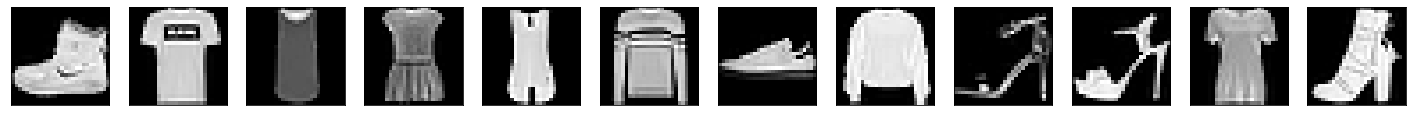

In [122]:
n = 12  
plt.figure(figsize=(25, 10));
for i in range(n):
    ax = plt.subplot(1, n, i + 1);
    plt.imshow(x_train[i]);
    plt.gray();
    ax.get_xaxis().set_visible(False);
    ax.get_yaxis().set_visible(False);
 
plt.show()

In [123]:
print(x_train.shape[0], ' - кількість зразків у тренувальній вибірці');
print('Форма зображення: ', x_train[0].shape);
print('Кількість классів: ', len(set(y_train)));

60000  - кількість зразків у тренувальній вибірці
Форма зображення:  (28, 28)
Кількість классів:  10


In [124]:
dim = 28*28; 
x_train = x_train.reshape(60000, dim);
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normilization [-1, 1]

### Побудова моделі нейромережі

In [125]:
adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) #optimizer
latent_dim = 100;

### Дискримінатор

In [126]:
def build_discriminator(): 
    model =  keras.Sequential()
    
    model.add(layers.Dense(1000, input_dim=dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));
     
    model.add(layers.Dense(512));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));

    model.add(layers.Dense(256));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));

    model.add(layers.Dense(150));
    model.add(layers.LeakyReLU(alpha=0.2));
    model.add(layers.Dropout(0.3));

    model.add(layers.Dense(1, activation='sigmoid'));
    model.compile(loss='binary_crossentropy', optimizer=adam);
    return model;

### Генератор

In [127]:
def build_generator():
    model =  keras.Sequential()
    model.add(layers.Dense(150, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)));
    model.add(layers.LeakyReLU(alpha=0.2));

    model.add(layers.Dense(256));
    model.add(layers.LeakyReLU(alpha=0.2));

    model.add(layers.Dense(512));
    model.add(layers.LeakyReLU(alpha=0.2));
    
    model.add(layers.Dense(1000));
    model.add(layers.LeakyReLU(alpha=0.2));

    model.add(layers.Dense(dim, activation='tanh'));

    model.compile(loss='binary_crossentropy', optimizer=adam);
    return model;

### Об'єднання моделей

In [128]:
discriminator = build_discriminator();
generator = build_generator();

discriminator.trainable = False;
gan_input = keras.Input(shape=(latent_dim,));
x = generator(gan_input);
gan_output = discriminator(x);
gan = keras.Model(inputs=gan_input, outputs=gan_output);
gan.compile(loss='binary_crossentropy', optimizer=adam);

### Функція візуалізації згенерованих зображень:

In [129]:
def plot_generated_images(epoch, generator):
    num_of_images = 7;
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim]);
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28);
    plt.figure();
    for i in range(num_of_images):
        plt.subplot(1, 7, i+1);
        plt.imshow(generated_images[i], cmap = 'gray');
        plt.axis('off');
        plt.tight_layout();
    plt.show()

### Навчання моделі

In [130]:
discrim_losses = [];

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size);
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim]);
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)];
            
            # Generate fake images
            generated_images = generator.predict(noise);
            X = np.concatenate([image_batch, generated_images]);

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size);
            y_dis[:batch_size] = 0.9; 
            # Train discriminator
            discriminator.trainable = True;
            d_loss = discriminator.train_on_batch(X, y_dis);
            discrim_losses.append(d_loss);

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim]);
            y_gen = np.ones(batch_size);
            discriminator.trainable = False;
            gan.train_on_batch(noise, y_gen);
        if ep % 10 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator);

epoch:  0


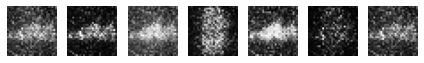

epoch:  10


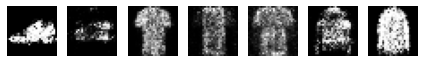

epoch:  20


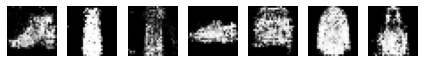

epoch:  30


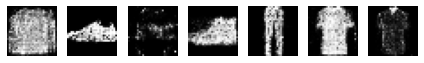

epoch:  40


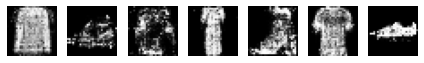

epoch:  50


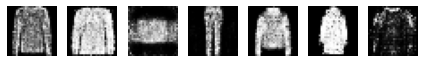

epoch:  60


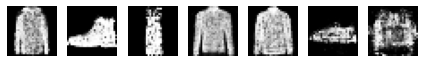

epoch:  70


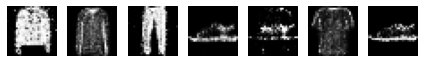

epoch:  80


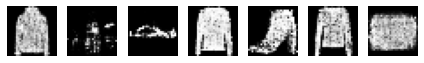

epoch:  90


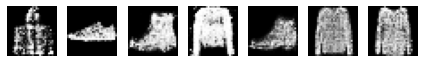

epoch:  100


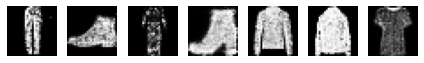

In [131]:
epochs = 100;
batch_size = 256;
train_model(epochs, batch_size);

### Втрати дискримінатора

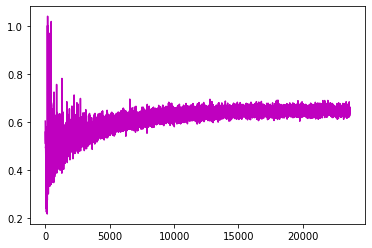

In [132]:
plt.plot(discrim_losses,color='m');